## 二値分類

### モジュールとサンプルデータを読み込む

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb

# 初期設定
pd.set_option('display.max_columns', None)
%matplotlib inline

# サンプルデータセットを読み込む
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target
print(f'df.shape                    : {df.shape}')
print(f'df["target"].value_counts() : {df["target"].value_counts().sort_index().to_dict()}')

df.head()

df.shape                    : (569, 31)
df["target"].value_counts() : {0: 212, 1: 357}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 特徴量と目的変数に分割

In [2]:
X = df.drop(columns='target')
y = df['target']
print(f'X.shape  : {X.shape}')
print(f'y.shape  : {y.shape}')

features = X.columns.to_list()
target = y.name
print(f'features : {features}')
print(f'target   : {target}')

X.shape  : (569, 30)
y.shape  : (569,)
features : ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
target   : target


### 訓練、テスト、バリデーション用に分割

In [3]:
from sklearn.model_selection import train_test_split

seed = 42
train_x, test_x, train_y, test_y = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x,
                                                      train_y,
                                                      test_size=0.2,
                                                      random_state=seed,
                                                      stratify=train_y)

print(f'df.shape      : {df.shape}')
print(f'train_x.shape : {train_x.shape}')
print(f'train_y.shape : {train_y.shape}')
print(f'valid_x.shape : {valid_x.shape}')
print(f'valid_y.shape : {valid_y.shape}')
print(f'test_x.shape  : {test_x.shape}')
print(f'test_y.shape  : {test_y.shape}')

df.shape      : (569, 31)
train_x.shape : (364, 30)
train_y.shape : (364,)
valid_x.shape : (91, 30)
valid_y.shape : (91,)
test_x.shape  : (114, 30)
test_y.shape  : (114,)


### XGBoostのデータ構造に変換

In [4]:
from sklearn.utils.class_weight import compute_sample_weight

dtrain = xgb.DMatrix(train_x, label=train_y, weight=compute_sample_weight('balanced', train_y))
dvalid = xgb.DMatrix(valid_x, label=valid_y, weight=compute_sample_weight('balanced', valid_y))
dtest = xgb.DMatrix(test_x, label=test_y, weight=compute_sample_weight('balanced', test_y))

### ハイパーパラメータの設定

In [5]:
params = {
    'objective': 'binary:logistic', # 二値分類問題(出力確率)
    'eval_metric': 'logloss',       # 学習用の指標(logloss)
}
num_round = 500                     # 決定木の本数

### 学習の実行

In [6]:
evals = [(dtrain, 'train'), (dvalid, 'eval')] # 学習に用いる検証用データ
evals_result = {}                             # 学習の経過を保存する箱

model = xgb.train(params,
                  dtrain,
                  num_round,
                  evals=evals,
                  evals_result=evals_result,
                  verbose_eval=0,             # 学習の経過の表示
                  early_stopping_rounds=20,   # アーリーストッピング         
                 )

ntree = model.best_ntree_limit
print(f'最適な決定木の本数: {ntree}')

最適な決定木の本数: 14


### 学習結果の可視化

[None, None]

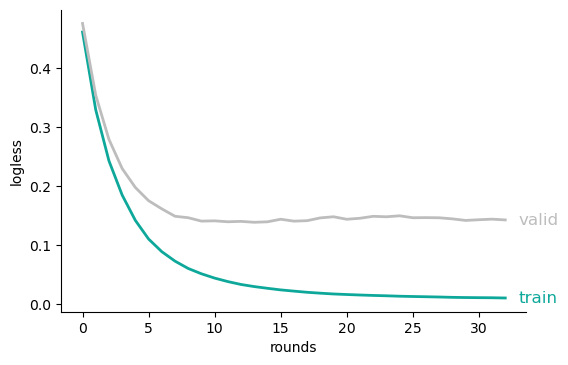

In [7]:
train_metric = evals_result['train']['logloss']
valid_metric = evals_result['eval']['logloss']

fig, ax = plt.subplots(dpi=100)

# タイトル
ax.set(xlabel='rounds', ylabel='logless')

# train
ax.plot(train_metric, linewidth=2, color='#0EA89B')
ax.text(x=len(train_metric),
        y=train_metric[-1],
        s='train',
        color='#0EA89B',
        va='center',
        fontsize=12)

# valid
ax.plot(valid_metric, linewidth=2, color='#BDBDBD')
ax.text(x=len(valid_metric),
        y=valid_metric[-1],
        s='valid',
        color='#BDBDBD',
        va='center',
        fontsize=12)

# 枠線を消す
[ax.spines[side].set_visible(False) for side in ['right', 'top']]

### スコアの確認

In [8]:
from sklearn.metrics import classification_report

# 指数表記をやめる
# np.set_printoptions(suppress=True)

"""
バリデーションデータで予測
"""
# 1である確率
valid_pred = model.predict(dvalid, ntree_limit=ntree)
# 出力確率を0と1に二値変換
valid_pred_class = np.round(valid_pred)

# F1値、適合率、再現率、正解率をまとめて算出
score_dict = classification_report(valid_y, valid_pred_class, output_dict=True)
df_score = pd.DataFrame(score_dict)
accuracy_score = df_score['accuracy'][0]
print(f'accuracy_score(vaild) : {accuracy_score}\n')
print(df_score[['0', '1']].T.to_markdown())
print('\n\n')

"""
テストデータで予測
"""
# 1である確率(0~1)
pred = model.predict(dtest, ntree_limit=ntree)
# 出力確率を0と1に二値変換
pred_class = np.round(pred)

# F1値、適合率、再現率、正解率、マクロ平均、加重平均をまとめて算出
score_dict = classification_report(test_y, pred_class, output_dict=True)
df_score = pd.DataFrame(score_dict)
accuracy_score = df_score['accuracy'][0]
print(f'accuracy_score(test) : {accuracy_score}\n')
print(df_score[['0', '1']].T.to_markdown())

accuracy_score(vaild) : 0.9560439560439561

|    |   precision |   recall |   f1-score |   support |
|---:|------------:|---------:|-----------:|----------:|
|  0 |    0.916667 | 0.970588 |   0.942857 |        34 |
|  1 |    0.981818 | 0.947368 |   0.964286 |        57 |



accuracy_score(test) : 0.9385964912280702

|    |   precision |   recall |   f1-score |   support |
|---:|------------:|---------:|-----------:|----------:|
|  0 |    0.906977 | 0.928571 |   0.917647 |        42 |
|  1 |    0.957746 | 0.944444 |   0.951049 |        72 |


### 特徴量の重要度の可視化

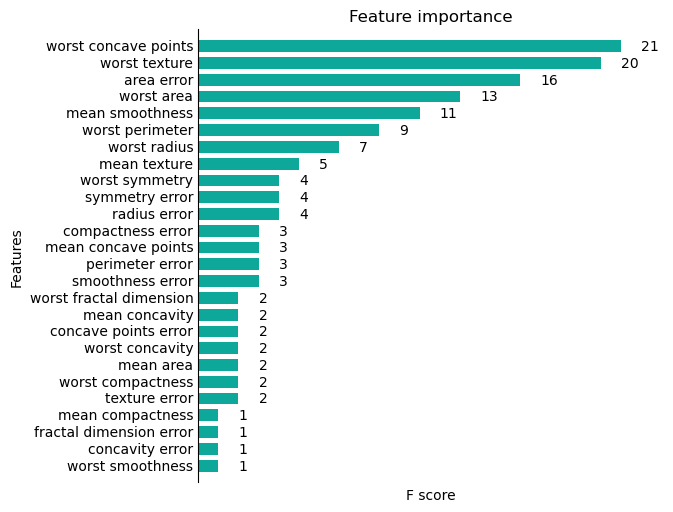

In [9]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

# プロットする
xgb.plot_importance(model, ax=ax, height=0.7, color='#0EA89B')

# 枠線を消す
[ax.spines[side].set_visible(False) for side in ['right', 'top', 'bottom']]

# グリッド線を消す
ax.grid(False)

# 目盛り、目盛りラベルを消す
ax.tick_params(labelbottom=False, bottom=False, left=False)

# y軸ラベルを垂直方向でセンター寄せする
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_verticalalignment('center')

# 横棒グラフとラベルの距離を調整する
ax.tick_params(axis='y', pad=0)

## 多値分類

### モジュールとサンプルデータを読み込む

In [89]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb

# サンプルデータセットを読み込む
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['target'] = wine.target
print(f'df.shape : {df.shape}')

df.head()

df.shape : (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### 特徴量と目的変数に分割

In [90]:
X = df.drop(columns='target')
y = df['target']
print(f'X.shape  : {X.shape}')
print(f'y.shape  : {y.shape}')

features = X.columns.to_list()
target = y.name
print(f'features : {features}')
print(f'target   : {target}')

X.shape  : (178, 13)
y.shape  : (178,)
features : ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
target   : target


### 訓練、テスト、バリデーション用に分割

In [91]:
from sklearn.model_selection import train_test_split

seed = 42
train_x, test_x, train_y, test_y = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x,
                                                      train_y,
                                                      test_size=0.2,
                                                      random_state=seed,
                                                      stratify=train_y)

print(f'df.shape      : {df.shape}')
print(f'train_x.shape : {train_x.shape}')
print(f'train_y.shape : {train_y.shape}')
print(f'valid_x.shape : {valid_x.shape}')
print(f'valid_y.shape : {valid_y.shape}')
print(f'test_x.shape  : {test_x.shape}')
print(f'test_y.shape  : {test_y.shape}')

df.shape      : (178, 14)
train_x.shape : (113, 13)
train_y.shape : (113,)
valid_x.shape : (29, 13)
valid_y.shape : (29,)
test_x.shape  : (36, 13)
test_y.shape  : (36,)


### XGBoostのデータ構造に変換

In [92]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)
dtest = xgb.DMatrix(test_x, label=test_y)

### ハイパーパラメータの設定

In [93]:
params = {
    'objective': 'multi:softprob', # 多値分類問題(出力確率)
    'num_class': 3,                # 目的変数のクラス数
    'eval_metric': 'mlogloss',     # 学習用の指標(Multiclass logloss)
}
num_round = 500                    # 決定木の本数

### 学習の実行

In [94]:
evals = [(dtrain, 'train'), (dvalid, 'eval')] # 学習に用いる検証用データ
evals_result = {}                             # 学習の経過を保存する箱

model = xgb.train(params,
                  dtrain,
                  num_round,
                  evals=evals,
                  evals_result=evals_result,
                  verbose_eval=0,             # 学習の経過の表示
                  early_stopping_rounds=20,   # アーリーストッピング         
                 )

ntree = model.best_ntree_limit
print(f'最適な決定木の本数: {ntree}')

最適な決定木の本数: 39


### 学習結果の可視化

[None, None]

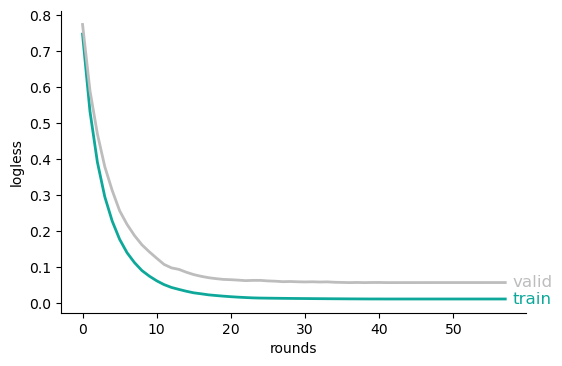

In [95]:
train_metric = evals_result['train']['mlogloss']
valid_metric = evals_result['eval']['mlogloss']

fig, ax = plt.subplots(dpi=100)

# タイトル
ax.set(xlabel='rounds', ylabel='logless')

# train
ax.plot(train_metric, linewidth=2, color='#0EA89B')
ax.text(x=len(train_metric),
        y=train_metric[-1],
        s='train',
        color='#0EA89B',
        va='center',
        fontsize=12)

# valid
ax.plot(valid_metric, linewidth=2, color='#BDBDBD')
ax.text(x=len(valid_metric),
        y=valid_metric[-1],
        s='valid',
        color='#BDBDBD',
        va='center',
        fontsize=12)

# 枠線を消す
[ax.spines[side].set_visible(False) for side in ['right', 'top']]

### スコアの確認

In [98]:
from sklearn.metrics import classification_report
from pprint import pprint

# 指数表記をやめる
# np.set_printoptions(suppress=True)

"""
バリデーションデータで予測
"""
# マルチクラス分類の確率を予測
valid_pred = model.predict(dvalid, ntree_limit=ntree)
# マルチクラス分類の値に多値変換
valid_pred_class = np.argmax(valid_pred, axis=1)

# F1値、適合率、再現率、正解率、マクロ平均、加重平均をまとめて算出
score_dict = classification_report(valid_y, valid_pred_class, output_dict=True)
print('validデータ')
pprint(score_dict)


"""
テストデータで予測
"""
# マルチクラス分類の確率を予測
pred = model.predict(dtest, ntree_limit=ntree)
# マルチクラス分類の値に多値変換
pred_class = np.argmax(pred, axis=1)

# F1値、適合率、再現率、正解率、マクロ平均、加重平均をまとめて算出
score_dict = classification_report(test_y, pred_class, output_dict=True)
print('testデータ')
pprint(score_dict)

validデータ
{'0': {'f1-score': 0.9411764705882353,
       'precision': 1.0,
       'recall': 0.8888888888888888,
       'support': 9},
 '1': {'f1-score': 0.9600000000000001,
       'precision': 0.9230769230769231,
       'recall': 1.0,
       'support': 12},
 '2': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 8},
 'accuracy': 0.9655172413793104,
 'macro avg': {'f1-score': 0.9670588235294119,
               'precision': 0.9743589743589745,
               'recall': 0.9629629629629629,
               'support': 29},
 'weighted avg': {'f1-score': 0.9651926977687627,
                  'precision': 0.9681697612732095,
                  'recall': 0.9655172413793104,
                  'support': 29}}
testデータ
{'0': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 12},
 '1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 14},
 '2': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 10},
 'accuracy': 1.0,
 'macro avg': {'f1-score': 1.0, 'precisi

### 特徴量の重要度の可視化

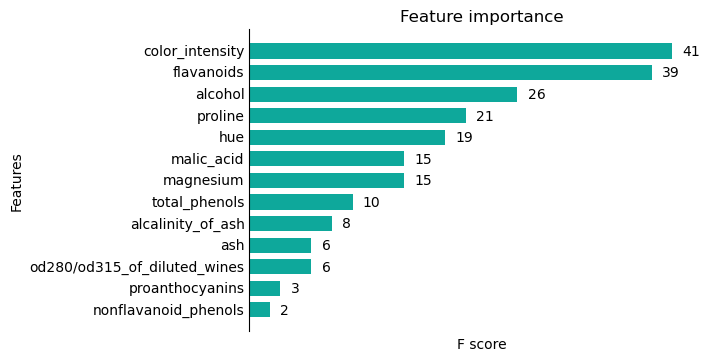

In [23]:
fig, ax = plt.subplots(dpi=100)

# プロットする
xgb.plot_importance(model, ax=ax, height=0.7, color='#0EA89B')

# 枠線を消す
[ax.spines[side].set_visible(False) for side in ['right', 'top', 'bottom']]

# グリッド線を消す
ax.grid(False)

# 目盛り、目盛りラベルを消す
ax.tick_params(labelbottom=False, bottom=False, left=False)

# y軸ラベルを垂直方向でセンター寄せする
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_verticalalignment('center')

# 横棒グラフとラベルの距離を調整する
ax.tick_params(axis='y', pad=0)

## 回帰

### モジュールとサンプルデータを読み込む

In [37]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb

# サンプルデータセットを読み込む
from sklearn.datasets import load_boston

boston = load_boston()
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df['target'] = boston.target
print(f'df.shape : {df.shape}')

df.head()

df.shape : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 特徴量と目的変数に分割

In [38]:
X = df.drop(columns='target')
y = df['target']
print(f'X.shape  : {X.shape}')
print(f'y.shape  : {y.shape}')

features = X.columns.to_list()
target = y.name
print(f'features : {features}')
print(f'target   : {target}')

X.shape  : (506, 13)
y.shape  : (506,)
features : ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
target   : target


### 訓練、テスト、バリデーション用に分割

In [40]:
from sklearn.model_selection import train_test_split

seed = 42
train_x, test_x, train_y, test_y = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed)
train_x, valid_x, train_y, valid_y = train_test_split(train_x,
                                                      train_y,
                                                      test_size=0.2,
                                                      random_state=seed)

print(f'df.shape      : {df.shape}')
print(f'train_x.shape : {train_x.shape}')
print(f'train_y.shape : {train_y.shape}')
print(f'valid_x.shape : {valid_x.shape}')
print(f'valid_y.shape : {valid_y.shape}')
print(f'test_x.shape  : {test_x.shape}')
print(f'test_y.shape  : {test_y.shape}')

df.shape      : (506, 14)
train_x.shape : (323, 13)
train_y.shape : (323,)
valid_x.shape : (81, 13)
valid_y.shape : (81,)
test_x.shape  : (102, 13)
test_y.shape  : (102,)


### XGBoostのデータ構造に変換

In [41]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)
dtest = xgb.DMatrix(test_x, label=test_y)

### ハイパーパラメータの設定

In [42]:
params = {
    'objective': 'reg:squarederror', # 多値分類問題(出力確率)
    'eval_metric': 'rmse',           # 学習用の指標(rmse)
}
num_round = 500                      # 決定木の本数

### 学習の実行

In [43]:
evals = [(dtrain, 'train'), (dvalid, 'eval')] # 学習に用いる検証用データ
evals_result = {}                             # 学習の経過を保存する箱

model = xgb.train(params,
                  dtrain,
                  num_round,
                  evals=evals,
                  evals_result=evals_result,
                  verbose_eval=0,             # 学習の経過の表示
                  early_stopping_rounds=20,   # アーリーストッピング         
                 )

ntree = model.best_ntree_limit
print(f'最適な決定木の本数: {ntree}')

最適な決定木の本数: 49


### 学習結果の可視化

[None, None]

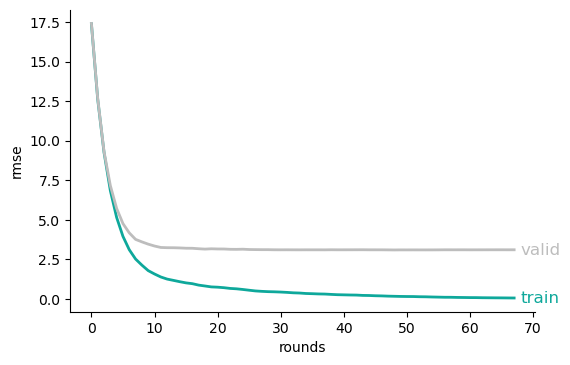

In [56]:
train_metric = evals_result['train']['rmse']
valid_metric = evals_result['eval']['rmse']

fig, ax = plt.subplots(dpi=100)

# タイトル
ax.set(xlabel='rounds', ylabel='rmse')

# train
ax.plot(train_metric, linewidth=2, color='#0EA89B')
ax.text(x=len(train_metric),
        y=train_metric[-1],
        s='train',
        color='#0EA89B',
        va='center',
        fontsize=12)

# valid
ax.plot(valid_metric, linewidth=2, color='#BDBDBD')
ax.text(x=len(valid_metric),
        y=valid_metric[-1],
        s='valid',
        color='#BDBDBD',
        va='center',
        fontsize=12)

# 枠線を消す
[ax.spines[side].set_visible(False) for side in ['right', 'top']]

### スコアの確認

In [67]:
from sklearn.metrics import r2_score

# バリデーションデータで予測
valid_pred = model.predict(dvalid, ntree_limit=ntree)
score = r2_score(valid_y, valid_pred)
print(f'r2_score(valid): {score:.4f}')

# テストデータで予測
pred = model.predict(dtest, ntree_limit=ntree)
score = r2_score(test_y, pred)
print(f'r2_score(test) : {score:.4f}')

r2_score(valid): 0.8652
r2_score(test) : 0.8617


### 予測と実測の可視化

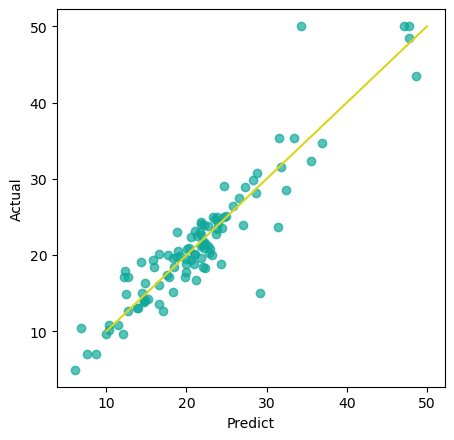

In [55]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

# タイトル
ax.set(xlabel='Predict', ylabel='Actual')

ax.scatter(pred, test_y, color='#0EA89B', alpha=0.7)
ax.plot([10, 50], [10, 50], color='#D9D51A')

### 特徴量の重要度の可視化

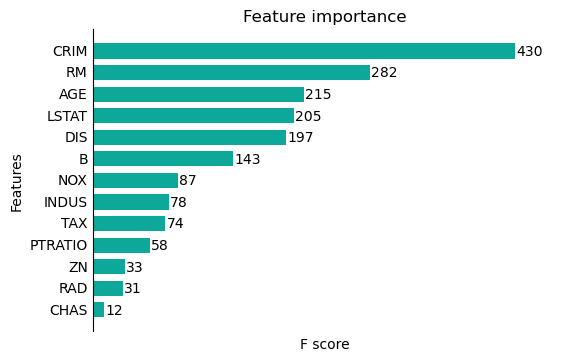

In [45]:
fig, ax = plt.subplots(dpi=100)

# プロットする
xgb.plot_importance(model, ax=ax, height=0.7, color='#0EA89B')

# 枠線を消す
[ax.spines[side].set_visible(False) for side in ['right', 'top', 'bottom']]

# グリッド線を消す
ax.grid(False)

# 目盛り、目盛りラベルを消す
ax.tick_params(labelbottom=False, bottom=False, left=False)

# y軸ラベルを垂直方向でセンター寄せする
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_verticalalignment('center')

# 横棒グラフとラベルの距離を調整する
ax.tick_params(axis='y', pad=0)